# CNN Keras

以下のカーネルを再現

Introduction to CNN Keras - Acc 0.997 (top 8%)

https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6/notebook

#1. Introduction

MNISTデータセットでトレーニングされた数字認識用の5層の順次畳み込みニューラルネットワーク

keras API（Tensorflowバックエンド）でビルド

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # 正解クラスをone-hotエンコーディング
from keras.models import Sequential  # モデルを生成するためのモジュール
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
# Dense: 全結合層のレイヤモジュール
# Dropout: ドロップアウトモジュール
# Flatten: 入力を平滑化するモジュール
# Conv2D: 2次元畳み込み層のモジュール
# MaxPool2D: 2次元最大プーリング層のモジュール

from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 2. Data preparation

## 2.1 Load data

In [0]:
# Load the data
# MNISTデータ（2019/11/17）
# train.csv、test.csvの内容は、ゼロから9までの手書き数字のグレースケールイメージ
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

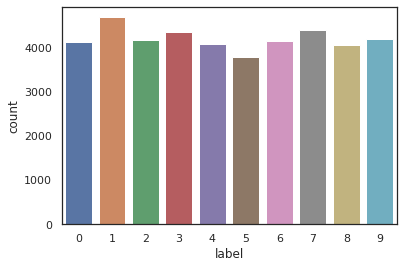

In [0]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
# trainを削除
del train 

# データの件数を集計し、ヒストグラムとして出力
g = sns.countplot(Y_train)

# データの値の頻度を計算
Y_train.value_counts()

## 2.2 Check for null and missing values

In [0]:
# Check the data
#列ごとに欠損値NaNをひとつでも含むか判定したうえでの統計量
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [0]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 2.3 Normalization

In [0]:
# Normalize the data
# CNNは[0..255]よりも[0..1]データでより速く収束
X_train = X_train / 255.0
test = test / 255.0

## 2.3 Reshape

In [0]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# (-1, image_rows, image_cols, image_color)
# 画像をリシェイプ 引数は画像数(-1は元サイズを保存するように自動計算)、縦x横、チャネル
#Kerasでは、チャンネルに対応する追加の次元が最後に必要
#MNIST画像はグレースケールであるため、1つのチャネルのみを使用
#RGB画像の場合、3つのチャネルがあり、784pxのベクトルを28x28x3の3Dマトリックスに再形成
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 2.5 Label encoding

In [0]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## 2.6 Split training and valdiation set

In [0]:
# Set the random seed
random_seed = 2

In [0]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

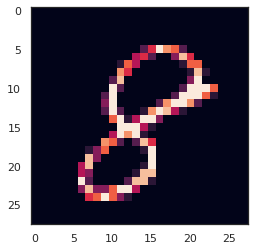

In [0]:
# Some examples
#df["列名"]["行名"]
g = plt.imshow(X_train[0][:,:,0])

# 3. CNN

## 3.1 Define the model

In [0]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
# Sequentialモデルは単純に、今の層のそれぞれのノードに、前の層の全ノードから矢印を引っ張ってくるイメージ

model = Sequential()

# addメソッドでレイヤーを追加
# 畳み込み層
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
# プーリング層
model.add(MaxPool2D(pool_size=(2,2)))
# ドロップアウトの適応
model.add(Dropout(0.25))

# 畳み込み層
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
# プーリング層
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# ドロップアウトの適応
model.add(Dropout(0.25))

# 全結合層向けに変形
model.add(Flatten())
# 全結合層
model.add(Dense(256, activation = "relu"))
# ドロップアウトの適応
model.add(Dropout(0.5))
# 全結合層
model.add(Dense(10, activation = "softmax"))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## 3.2 Set the optimizer and annealer

In [0]:
# Define the optimizer
# 勾配の2乗の指数移動平均を取る
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [0]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
# Set a learning rate annealer
# 訓練中にモデル内部の状態と統計量を可視化
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

## 3.3 Data augmentation

In [0]:
# Without data augmentation i obtained an accuracy of 0.98114
# history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [0]:
# With data augmentation to prevent overfitting (accuracy 0.99286)
# データ拡張
# rotation_range：画像を回転させる角度
# width_shift_range：水平にシフトする画像横幅に対する割合
# height_shift_range：水平にシフトする画像縦に対する割合
# horizontal_flip：水平方向反転
# vertical_flip：垂直方向反転
# zoom_range：拡大縮小範囲
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [0]:
# Fit the model
# 固定回数（データセットの反復）の試行でモデルを学習
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/1





 - 265s - loss: 0.4317 - acc: 0.8611 - val_loss: 0.0778 - val_acc: 0.9769


In [0]:
history.history

{'acc': [0.8609534918038279],
 'loss': [0.43200577321057987],
 'lr': [0.001],
 'val_acc': [0.9769047508920942],
 'val_loss': [0.0778160471888259]}

# 4. Evaluate the model

## 4.1 Training and validation curves

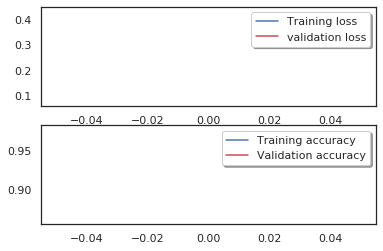

In [0]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 4.2 Confusion matrix

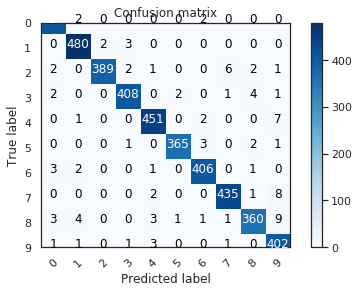

In [0]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

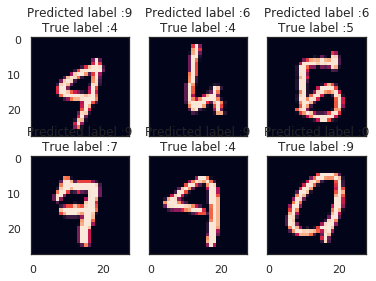

In [0]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [0]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [0]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)